In [1]:
import os
from os.path import isdir

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

D:\Miniconda2\envs\py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Loading and Reshaping Data

We'll start by reading in the data we extracted earlier. For these simple classifiers we won't be worrying about the words not in the command words set.

In [2]:
words = [word for word in os.listdir('data/train')]
command_words = sorted(['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go'])


def load_word(fold, word):   
    X = np.load('data/{}/{}/mfcc.npy'.format(fold, word))
    y = np.full(shape=X.shape[0],
                fill_value=word if word in command_words else 'unknown')
    return X, y

def get_fold_data(fold, words=words):
    """
    Reads in mfcc data  and labels for entire fold
    fold: 'train', 'validation', or 'test'
    words: list of words to extract
    """
    
    X_total = np.array([]).reshape(0, 20 , 32)
    y_total = np.array([])
    for word in words:
        X_word, y_word = load_word(fold, word)
        X_total = np.vstack([X_total, X_word])
        y_total = np.append(y_total, y_word)
        
    return X_total, y_total

X_train, y_train = get_fold_data('train', command_words)
X_val, y_val = get_fold_data('validation', command_words)
X_test, y_test = get_fold_data('test', command_words)

print('Number of training samples: {}'.format(len(X_train)))
print('Number of validation samples: {}'.format(len(X_val)))
print('Number of testing samples: {}'.format(len(X_test)))
print('Shape of each sample: {}'.format(X_train[0].shape))

Number of training samples: 30769
Number of validation samples: 3703
Number of testing samples: 4074
Shape of each sample: (20, 32)


In [3]:
#holds counts of each word for each fold
word_counts = pd.DataFrame()
for fold, y in zip(['train', 'validation', 'test'], [y_train, y_val, y_test]):
    word_counts[fold] = pd.Series(y).value_counts()
word_counts = word_counts.sort_index()
word_counts

,train,validation,test
down,3134,377,406
go,3106,372,402
left,3037,352,412
no,3130,406,405
off,2970,373,402
on,3086,363,396
right,3019,363,396
stop,3111,350,411
up,2948,350,425
yes,3228,397,419


Now that we've loaded in the data, we'll need to reformat it a little so that we can feed them into our neural networks. For the y values, we'll need to transform the labelled words into one hot encoded integers. We'll also need to reshape the X values for the convolutional neural network later, so that it can be treated as an image. For now, we'll just reformat the y values.

In [4]:
def reformat_X(X):
    """
    Reshapes X into an 'image' of depth 1
    """
    X = X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    return X

def reformat_y(y):
    """
    Formats y into one hot encoded integers
    """
    y = LabelEncoder().fit_transform(y)
    y = to_categorical(y)
    return y

y_train_hot = reformat_y(y_train)
y_val_hot = reformat_y(y_val)
y_test_hot = reformat_y(y_test)
    
print('X_train shape: {}'.format(X_train.shape))
print('y_train_hot shape: {}'.format(y_train_hot.shape))

X_train shape: (30769, 20, 32)
y_train_hot shape: (30769, 10)


# Single Layer Perceptron

Let's see how a single layer perceptron performs on the data. We'll need to flatten the X values and normalize them first so that the optimizer won't get stuck. For this model, we'll be using the default Adam optimizer. We'll also add an early stopping monitor so that the model stops running once the validation loss hasn't decreased in 3 epochs. This will shorten training time and help avoid overfitting.

In [5]:
model = Sequential()
model.add(InputLayer(input_shape=(X_train[0].shape)))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.fit(X_train, y_train_hot, batch_size=128, epochs=100,
          validation_data=(X_val, y_val_hot), callbacks=[EarlyStopping(patience=3)])

Train on 30769 samples, validate on 3703 samples
Epoch 1/100
30769/30769 [==============================] - 3s 107us/step - loss: 1.6816 - acc: 0.4397 - val_loss: 1.4309 - val_acc: 0.5347
Epoch 2/100
30769/30769 [==============================] - 1s 22us/step - loss: 1.3721 - acc: 0.5519 - val_loss: 1.3854 - val_acc: 0.5571
Epoch 3/100
30769/30769 [==============================] - 1s 22us/step - loss: 1.3366 - acc: 0.5644 - val_loss: 1.3691 - val_acc: 0.5687
Epoch 4/100
30769/30769 [==============================] - 1s 23us/step - loss: 1.3198 - acc: 0.5703 - val_loss: 1.3626 - val_acc: 0.5647
Epoch 5/100
30769/30769 [==============================] - 1s 22us/step - loss: 1.3105 - acc: 0.5768 - val_loss: 1.3582 - val_acc: 0.5712
Epoch 6/100
30769/30769 [==============================] - 1s 23us/step - loss: 1.3031 - acc: 0.5800 - val_loss: 1.3626 - val_acc: 0.5690
Epoch 7/100
30769/30769 [==============================] - 1s 22us/step - loss: 1.2968 - acc: 0.5773 - val_loss: 1.3570 - 

In [6]:
score = model.evaluate(x=X_test, y=y_test_hot)

for name, value in zip(model.metrics_names, score):
    print(name, value)

4074/4074 [==============================] - 0s 33us/step
loss 1.3769945000455142
acc 0.5608738340404493


As expected, the single layer perceptron doesn't perform too well. Still, with 10 possible voice commands and only 10 epochs an accuracy of ~56% isn't that bad! Let's plot a confusion matrix to see what it had difficulty classifying.

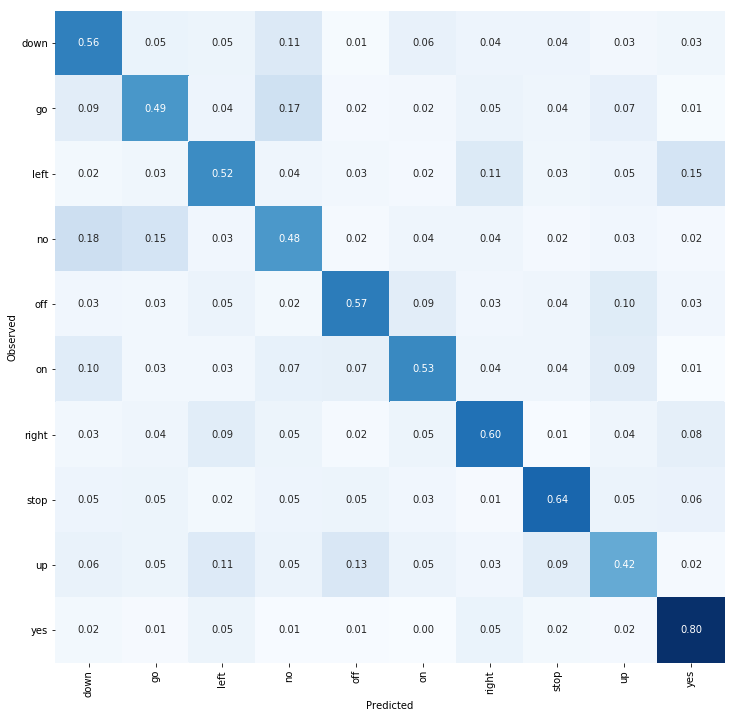

In [7]:
def plot_confusion_matrix(y_pred, y_test):
    y_pred_labels = np.array([command_words[y] for y in y_pred])
    conf_matrix = confusion_matrix(y_test, y_pred_labels)
    conf_matrix_percent = np.divide(conf_matrix.T, conf_matrix.sum(axis=1)).T
    fig, ax = plt.subplots(figsize=(12, 12))    
    sns.heatmap(conf_matrix_percent, cmap='Blues', ax=ax, annot=True, fmt='.2f', cbar=False)
    ax.set_xticklabels(command_words, rotation=90)
    ax.set_yticklabels(command_words, rotation=0)
    ax.set_ylabel('Observed')
    ax.set_xlabel('Predicted')
    plt.show()
    return conf_matrix_percent
    
y_pred_perceptron = model.predict_classes(x=X_test)
plot_confusion_matrix(y_pred_perceptron, y_test);

This confusion matrix tells us a little more about how the model performed. It confuses similar sounding words like "no" and "go" and "left" and "yes". This is to be expected, but notice how it also confuses "left" with "right" ~11% of the time. These words are opposite in meaning and sound very different! This is an example of words that we'll want to make sure we don't confuse. Hopefully, the more sophisticated models will have an easier time distinguishing these words apart.

# Simple Feedforward Neural Network

Now that we have a baseline performance of a single layer perceptron, let's try adding a few hidden layers and see how that impacts the performance. We'll use the same process with the early stopping monitor and the default Adam optimizer.

In [8]:
model2 = Sequential()
model2.add(InputLayer(input_shape=(X_train[0].shape)))
model2.add(Flatten())
model2.add(BatchNormalization())
model2.add(Dense(64, activation='relu'))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(10, activation='softmax'))
model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model2.fit(X_train, y_train_hot, batch_size=128, epochs=100, verbose=1,
          validation_data=(X_val, y_val_hot), callbacks=[EarlyStopping(patience=3)])

Train on 30769 samples, validate on 3703 samples
Epoch 1/100
30769/30769 [==============================] - 1s 43us/step - loss: 1.2765 - acc: 0.5548 - val_loss: 0.8538 - val_acc: 0.7005
Epoch 2/100
30769/30769 [==============================] - 1s 28us/step - loss: 0.7240 - acc: 0.7511 - val_loss: 0.6811 - val_acc: 0.7699
Epoch 3/100
30769/30769 [==============================] - 1s 29us/step - loss: 0.5752 - acc: 0.8002 - val_loss: 0.6262 - val_acc: 0.7842
Epoch 4/100
30769/30769 [==============================] - 1s 29us/step - loss: 0.4861 - acc: 0.8340 - val_loss: 0.5997 - val_acc: 0.7975
Epoch 5/100
30769/30769 [==============================] - 1s 29us/step - loss: 0.4267 - acc: 0.8512 - val_loss: 0.5944 - val_acc: 0.8058
Epoch 6/100
30769/30769 [==============================] - 1s 29us/step - loss: 0.3836 - acc: 0.8668 - val_loss: 0.5971 - val_acc: 0.8061
Epoch 7/100
30769/30769 [==============================] - 1s 32us/step - loss: 0.3466 - acc: 0.8772 - val_loss: 0.6108 - v

In [9]:
score = model2.evaluate(x=X_test, y=y_test_hot)

for name, value in zip(model2.metrics_names, score):
    print(name, value)

4074/4074 [==============================] - 0s 41us/step
loss 0.6464945423029542
acc 0.8053510063234123


This time our accuracy improved to ~81%. Not too bad!

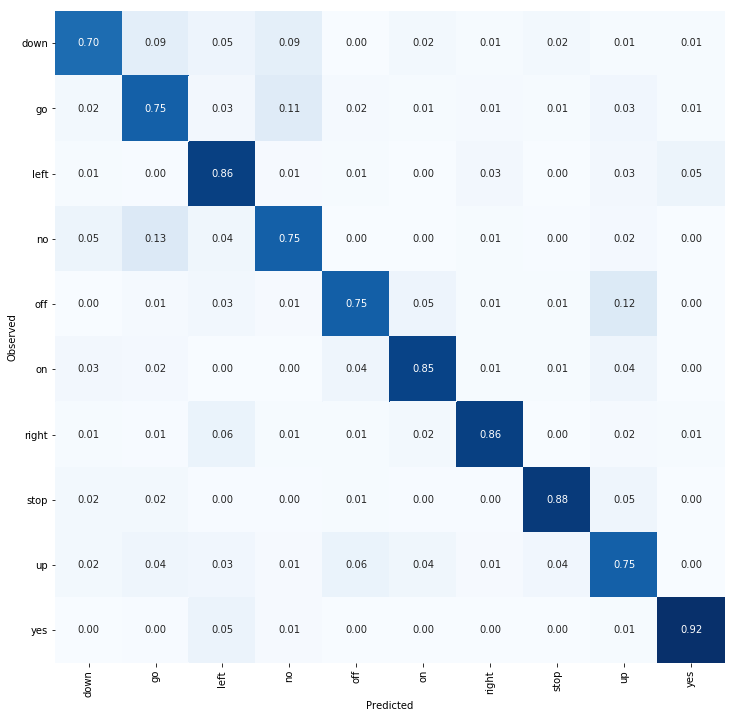

In [10]:
y_pred_ff = model2.predict_classes(x=X_test)
plot_confusion_matrix(y_pred_ff, y_test);

This network shows a much better confusion matrix. It still tends to confuse similar sounding words, but notice that the confusion for "left" and "right" has already dropped significantly. 

We've shown that even a simple feedforward neural network can classify speech fairly well without too much effort. Looking forward, every additional percent in accuracy increase will become more difficult. We may need much more sophisticated models and data processing to get accuracy near 90%.

# Dealing with Unknown Words

So far, we've left the non-command words out of the analysis. The end goal is to have a model that will classify words it hasn't heard before as unknown. One way of doing this is to implement a threshold on the probabilities given by the softmax output layer - in other words, if the model is not confident enough in any particular word for a given input, it will classify it as unknown.

Let's run these trained models on the entire dataset to see what kind of probabilities it outputs for correctly classified words, incorrectly classified command words, and words that the model has not seen before. We will only be looking at the maximum confidence for each input sample.

In [11]:
data = [get_fold_data(fold) for fold in ['train', 'validation', 'test']]

In [12]:
def create_summary_df(X, y, model):
    label_dict = {i: word for i, word in enumerate(command_words+['unknown'])}
    df = pd.DataFrame()
    df['y_obs_words'] = y
    try:
        df['y_pred_classes'] = model.predict_classes(X)
    except:
        X = reformat_X(X)
        df['y_pred_classes'] = model.predict_classes(X)
    df['y_pred_words'] = df['y_pred_classes'].map(label_dict)
    y_pred_proba = model.predict(X)
    df['max_confidences'] = y_pred_proba.max(axis=1)
    
    def classify_labels(row):
        if row['y_obs_words'] == 'unknown':
            return 'word not in training set'
        elif row['y_obs_words'] == row['y_pred_words']:
            return 'correct'
        else:
            return 'misclassified'
        
    df['labels'] = df.apply(classify_labels, axis=1)
    return df

def plot_hist(df, ax, color, ylabel, xlabel=False, title=False):
        hist = df[['labels', 'max_confidences']].hist(by='labels', color=color, ax=ax)    
        hist[0].set_ylabel(ylabel)   
        if not title:
            for ax in hist:
                ax.set_title('')
        if xlabel:
            for ax in hist:
                ax.set_xlabel('maximum classification confidence')          
        return hist
    
def plot_hist_grid(data, model, title=''):
    train_df = create_summary_df(data[0][0], data[0][1], model)
    val_df = create_summary_df(data[1][0], data[1][1], model)
    test_df = create_summary_df(data[2][0], data[2][1], model)
    
    fig, ax = plt.subplots(3, 3, figsize=(15 , 12))
    plot_hist(train_df, color='C0', title=True, ylabel='train samples', ax=ax[0])
    plot_hist(val_df, color='C1', ylabel='validation samples', ax=ax[1])
    plot_hist(test_df, color='C2', ylabel='test samples', xlabel=True, ax=ax[2])
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle(title)
    return ax

def plot_roc_curve(df):
    y_true = (df['labels']!='correct')

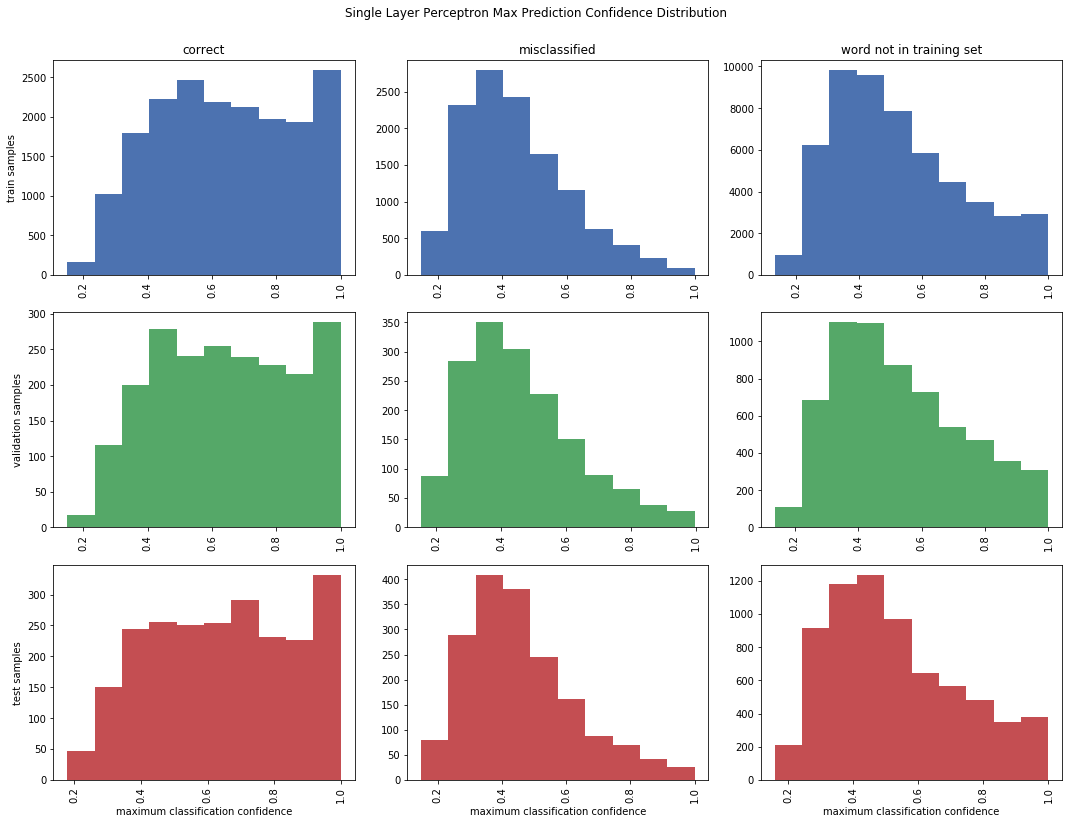

In [14]:
plot_hist_grid(data, model, title='Single Layer Perceptron Max Prediction Confidence Distribution');

For correctly classified words, the single layer perceptron can range from being moderately confident to very confident in its prediction. The model tends to be unconfident on the misclassified words that it knows, so implementing a threshold would be pretty successful for classifying these as unknown. The prediction confidences follow a similar distribution for the words not in the command words training set, but the model appears to be very confident in many of these words. This could be due to the words sounding familiar to ones it does know (e.g. "nine" and "no").

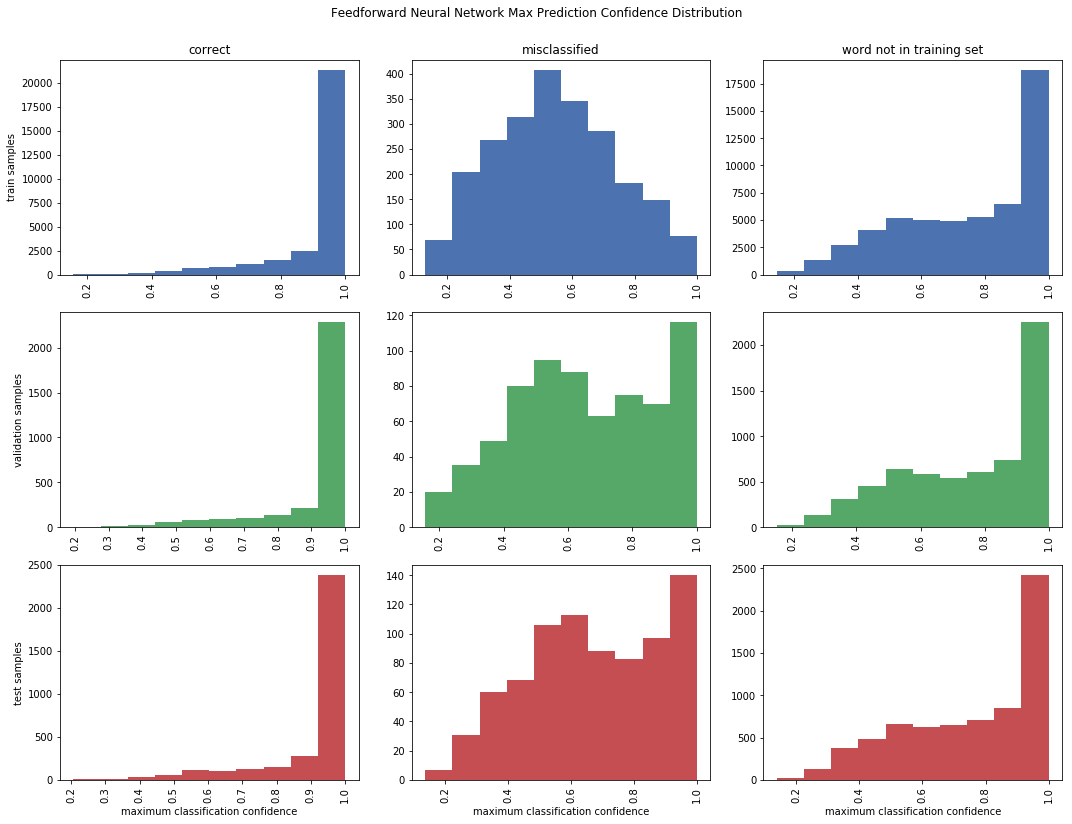

In [15]:
plot_hist_grid(data, model2, title='Feedforward Neural Network Max Prediction Confidence Distribution');

These results are somewhat surprising. For words it correctly classifies, the feedforward neural network appears to be very confident. However, the model appears to be confident in its predictions as well for both words it classifies incorrectly and for unknown words. This means that implementing a simple threshold to classify as "unknown" would still falsely classify many unknown words. For the future final models, we will probably need to implement a more complex method of determining unknowns, maybe by looking at the entire distribution of probabilities and not just the maximum confidence.

In [15]:
df['is_correct'] = (df['labels']=='correct')
df.head()

,y_obs_words,y_pred_classes,y_pred_words,max_confidences,labels,is_correct
0,unknown,8,up,0.435487,word not in training set,False
1,unknown,6,right,0.595277,word not in training set,False
2,unknown,6,right,0.509213,word not in training set,False
3,unknown,6,right,0.538076,word not in training set,False
4,unknown,6,right,0.629134,word not in training set,False


In [16]:
df.describe()

,y_pred_classes,max_confidences
count,84843.000000,84843.000000
mean,4.523555,0.539320
std,2.946562,0.209397
min,0.000000,0.134119
25%,2.000000,0.371764
50%,5.000000,0.499669
75%,7.000000,0.686709
max,9.000000,0.999994


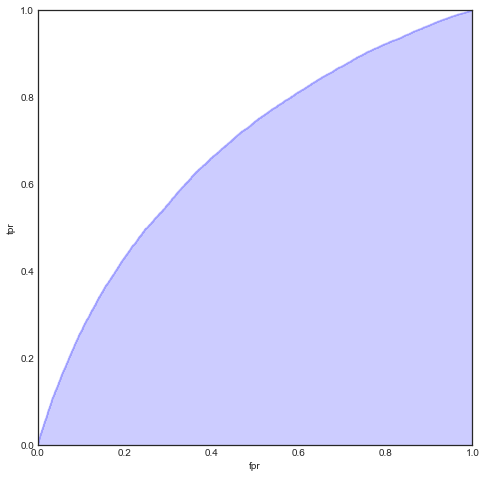

In [17]:
fig, ax = plt.subplots(figsize=(8, 8))
fpr, tpr, _ = roc_curve(df['is_correct'], df['max_confidences'])

plt.step(fpr, tpr, color='b', alpha=0.2,
         where='post')
plt.fill_between(fpr, tpr, step='post', alpha=0.2,
                 color='b')

plt.xlabel('fpr')
plt.ylabel('tpr')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
ax.set_aspect('equal');

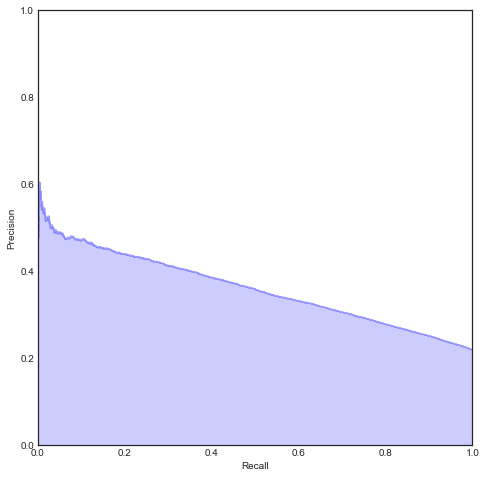

In [18]:
fig, ax = plt.subplots(figsize=(8, 8))
precision, recall, _ = precision_recall_curve(df['is_correct'], df['max_confidences'])

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
ax.set_aspect('equal');